# Violence Prediction - Ethnicity

In [ ]:
# Python vanilla libs
import os
import datetime
import logging
import importlib

# Aif360 content
# from aif360.sklearn.preprocessing import LearnedFairRepresentations
# from aif360.sklearn.inprocessing import AdversarialDebiasing
# from modules.aif360.aif360_instance import Aif360Instance
from aif360.sklearn.postprocessing import RejectOptionClassifierCV, PostProcessingMeta
from aif360.sklearn.metrics import consistency_score
from aif360.sklearn.detectors import bias_scan
from aif360.datasets.structured_dataset import StructuredDataset
from aif360.datasets.binary_label_dataset import BinaryLabelDataset
from aif360.datasets.standard_dataset import StandardDataset
# from aif360.examples.common_utils import compute_metrics


# Other usefull third party libraries
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Markdown, display, HTML

# Finally, the own modules
from modules.gen_purp.get_repo import get_uci_repo
from modules.gen_purp.data_preprocessing import preprocessing as aif360prep
from modules.display import data_display
from modules.ml import ml_methods
from modules.aifairn360.dataset import inst_dataset
from modules.metrics import calc_metrics
from modules.aifairn360 import preprocessing, inprocessing, postprocessing

# And the config
now = datetime.datetime.now()

cfg = {
    'main_path': os.getcwd(),
    'now': now,
    'read': {
        'sep': ','
    },
    # All params concerning the student performance dataset
    'student_ds': {
        'data_id': 211,
        'data_name': 'violence_prediction',
    },
    # All params for displaying data
    'display': {
        'out_file': os.path.join(os.getcwd(), 'out', f'display_{now.day}-{now.month}-{now.year}.txt'),
        'inst': ('head', 'summary', 'describe', 'skew', 'standard_error')
    }
}

## Initial data inspection

In [2]:
# Get the data
data = get_uci_repo(main_path=cfg['main_path'], data_id=cfg['student_ds']['data_id'], data_name=cfg['student_ds']['data_name'])
feat, targets = data[0], data[1]

In [3]:
# Display the features
display(HTML(feat.head(10).to_html()))

,Unnamed: 0,State,pop,perHoush,pctBlack,pctWhite,pctAsian,pctHisp,pct12-21,pct12-29,pct16-24,pct65up,persUrban,pctUrban,medIncome,pctWwage,pctWfarm,pctWdiv,pctWsocsec,pctPubAsst,pctRetire,medFamIncome,perCapInc,whitePerCap,blackPerCap,NAperCap,asianPerCap,otherPerCap,hispPerCap,persPoverty,pctPoverty,pctLowEdu,pctNotHSgrad,pctCollGrad,pctUnemploy,pctEmploy,pctEmployMfg,pctEmployProfServ,pctOccupManu,pctOccupMgmt,pctMaleDivorc,pctMaleNevMar,pctFemDivorc,pctAllDivorc,persPerFam,pct2Par,pctKids2Par,pctKids-4w2Par,pct12-17w2Par,pctWorkMom-6,pctWorkMom-18,kidsBornNevrMarr,pctKidsBornNevrMarr,numForeignBorn,pctFgnImmig-3,pctFgnImmig-5,pctFgnImmig-8,pctFgnImmig-10,pctImmig-3,pctImmig-5,pctImmig-8,pctImmig-10,pctSpeakOnlyEng,pctNotSpeakEng,pctLargHousFam,pctLargHous,persPerOccupHous,persPerOwnOccup,persPerRenterOccup,pctPersOwnOccup,pctPopDenseHous,pctSmallHousUnits,medNumBedrm,houseVacant,pctHousOccup,pctHousOwnerOccup,pctVacantBoarded,pctVacant6up,medYrHousBuilt,pctHousWOphone,pctHousWOplumb,ownHousLowQ,ownHousMed,ownHousUperQ,ownHousQrange,rentLowQ,rentMed,rentUpperQ,rentQrange,medGrossRent,medRentpctHousInc,medOwnCostpct,medOwnCostPctWO,persEmergShelt,persHomeless,pctForeignBorn,pctBornStateResid,pctSameHouse-5,pctSameCounty-5,pctSameState-5,numPolice,policePerPop,policeField,policeFieldPerPop,policeCalls,policCallPerPop,policCallPerOffic,policePerPop2,racialMatch,pctPolicWhite,pctPolicBlack,pctPolicHisp,pctPolicAsian,pctPolicMinority,officDrugUnits,numDiffDrugsSeiz,policAveOT,landArea,popDensity,pctUsePubTrans,policCarsAvail,policOperBudget,pctPolicPatrol,gangUnit,pctOfficDrugUnit,policBudgetPerPop
0,0,NJ,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,11980,100.0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,30233,13600,5725,27101,5115.0,22838,227,1.96,5.81,9.90,48.18,2.70,64.55,14.65,28.82,5.49,50.73,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36,1277,8.69,13.00,20.99,30.93,0.93,1.39,2.24,3.30,85.68,1.37,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,98.37,91.01,3.12,37.50,1959,0.00,0.28,215900,262600,326900,111000,685,1001,1001,316,1001,23.8,21.1,14.0,11,0,10.66,53.72,65.29,78.09,89.14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.5,1845.9,9.63,NaN,NaN,NaN,NaN,0.00,NaN
1,1,PA,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,23123,100.0,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,20191,18137,0,20074,5250.0,12222,885,3.98,5.61,13.72,29.89,2.43,61.96,12.26,29.28,6.39,37.64,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24,1920,5.21,8.65,13.33,22.50,0.43,0.72,1.11,1.87,87.79,1.81,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,97.15,84.88,0.00,18.33,1958,0.31,0.14,136300,164200,199900,63600,467,560,672,205,627,27.6,20.7,12.5,0,0,8.30,77.17,71.27,90.22,96.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2186.7,3.84,NaN,NaN,NaN,NaN,0.00,NaN
2,2,OR,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,29344,100.0,35669,82.00,1.15,55.73,22.25,2.94,14.56,42112,16946,17103,16644,21606,15528,5954.0,8405,1389,4.75,2.80,9.09,30.13,4.01,69.80,15.95,21.52,8.79,32.48,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88,1468,16.42,23.98,32.08,35.63,0.82,1.20,1.61,1.78,93.11,1.14,2.97,2.05,2.42,2.69,2.06,64.18,2.03,47.46,3,544,95.68,57.79,0.92,7.54,1976,1.55,0.12,74700,90400,112000,37300,370,428,520,150,484,24.1,21.7,11.6,16,0,5.00,44.77,36.60,61.26,82.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.6,2780.9,4.37,NaN,NaN,NaN,NaN,0.00,NaN
3,3,NY,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,0,0.0,20580,68.15,0.24,38.95,39.48,11.71,18.33,26501,10810,10909,9984,4941,3541,2451.0,4391,2831,17.23,11.05,33.68,10.81,9.86,54.74,31.22,27.43,26.76,22.71,10.98,28.15,14.47,12.91,2.98,64.02,62.36,65.38,67.43,59.59,70.27,561,3.84,339,13.86,13.86,15.34,15.34,0.28,0.28,0.31,0.31,94.98,0.56,3.93,2.56,2.37,2.51,2.20,58.18,1.21,45.66,3,669,91.19,54.89,2.54,57.85,1939,7.00,0.87,36400,49

In [4]:
# Display the targets
display(HTML(targets.head(10).to_html()))
# Check all possible target classifications

,Unnamed: 0,murders,murdPerPop,rapes,rapesPerPop,robberies,robbbPerPop,assaults,assaultPerPop,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,violentPerPop,nonViolPerPop
0,0,0,0.00,0.0,0.00,1.0,8.20,4.0,32.81,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
1,1,0,0.00,1.0,4.25,5.0,21.26,24.0,102.05,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
2,2,3,8.30,6.0,16.60,56.0,154.95,14.0,38.74,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
3,3,0,0.00,10.0,57.86,10.0,57.86,33.0,190.93,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
4,4,0,0.00,NaN,NaN,4.0,32.04,14.0,112.14,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79
5,5,7,4.63,77.0,50.98,136.0,90.05,449.0,297.29,2094.0,1386.46,7690.0,5091.64,454.0,300.60,134.0,88.72,442.95,6867.42
6,6,0,0.00,4.0,13.53,9.0,30.44,54.0,182.66,110.0,372.09,288.0,974.19,144.0,487.10,17.0,57.50,226.63,1890.88
7,7,8,13.13,34.0,55.79,98.0,160.80,128.0,210.02,608.0,997.60,2250.0,3691.79,125.0,205.10,9.0,14.77,439.73,4909.26
8,8,0,0.00,35.0,43.87,16.0,20.05,41.0,51.39,425.0,532.66,3149.0,3946.71,206.0,258.18,8.0,10.03,115.31,4747.58
9,9,29,26.88,141.0,130.69,453.0,419.89,1043.0,966.77,2397.0,2221.81,6121.0,5673.63,1070.0,991.80,18.0,16.68,1544.24,8903.93


The dataset is targeted as regression task. Thus, it may be interesting to see what happens if we try to get as close to the actual violence per population as possible

### Data cleaning tasks:

- Fill the NaNs where possible
- Transfer to dummy values
- Extract the last semester as target

In [31]:
# First extract the column to protect
protect_cols = feat[['pctBlack', 'pctWhite', 'pctAsian', 'pctHisp']]
# Then drop all unwanted cols
# dropped = feat.drop(columns=['Unnamed: 0', 'Dalc'])
# Convert the booleans
# dropped = dropped.map(lambda x: 1 if isinstance(x, object) and x == 'yes' else 0 if isinstance(x, object) and x == 'no' else x)
# Then convert the remaining cols to dummies
dummies = pd.get_dummies(feat)
# Finally, fill the Nulls with the (rounded) median
cleaned = dummies.fillna(feat.median(numeric_only=True).round())
# Assign the target as dependent variable
cleaned = cleaned.assign(violentPerPop=targets['violentPerPop'])
# cleaned = cleaned.assign(Dalc=protect_col)
print(cleaned.shape)

(2215, 174)


In [15]:
import pprint
pprint.pp(cleaned.columns.to_list())

['Unnamed: 0',
 'pop',
 'perHoush',
 'pctBlack',
 'pctWhite',
 'pctAsian',
 'pctHisp',
 'pct12-21',
 'pct12-29',
 'pct16-24',
 'pct65up',
 'persUrban',
 'pctUrban',
 'medIncome',
 'pctWwage',
 'pctWfarm',
 'pctWdiv',
 'pctWsocsec',
 'pctPubAsst',
 'pctRetire',
 'medFamIncome',
 'perCapInc',
 'whitePerCap',
 'blackPerCap',
 'NAperCap',
 'asianPerCap',
 'otherPerCap',
 'hispPerCap',
 'persPoverty',
 'pctPoverty',
 'pctLowEdu',
 'pctNotHSgrad',
 'pctCollGrad',
 'pctUnemploy',
 'pctEmploy',
 'pctEmployMfg',
 'pctEmployProfServ',
 'pctOccupManu',
 'pctOccupMgmt',
 'pctMaleDivorc',
 'pctMaleNevMar',
 'pctFemDivorc',
 'pctAllDivorc',
 'persPerFam',
 'pct2Par',
 'pctKids2Par',
 'pctKids-4w2Par',
 'pct12-17w2Par',
 'pctWorkMom-6',
 'pctWorkMom-18',
 'kidsBornNevrMarr',
 'pctKidsBornNevrMarr',
 'numForeignBorn',
 'pctFgnImmig-3',
 'pctFgnImmig-5',
 'pctFgnImmig-8',
 'pctFgnImmig-10',
 'pctImmig-3',
 'pctImmig-5',
 'pctImmig-8',
 'pctImmig-10',
 'pctSpeakOnlyEng',
 'pctNotSpeakEng',
 'pctLargHous

In [25]:
from aif360.datasets.regression_dataset import RegressionDataset
# For now let's say previledged is when the share of the population is above 20%
ds = RegressionDataset(
    df=cleaned,
    protected_attribute_names=['pctBlack', 'pctWhite', 'pctAsian', 'pctHisp'],
    dep_var_name='violentPerPop',
    privileged_classes=[lambda x: 1 if x >= 0.25 else 0],
    
)

In [26]:
ds_train, ds_test = ds.split([0.8], shuffle=True)
priv_group = [	{'pctWhite': 1}] #,{'pctBlack': 1 }, {'pctAsian': 1}, {'pctHisp': 1}
unpriv_group = [{'pctBlack': 0},  {'pctAsian': 0}, {'pctHisp': 0}] #{'pctWhite': 0},

In [ ]:
# Check the mean difference between more and less Workday alchohol consumption
from aif360.metrics import RegressionDatasetMetric
non_mit_metric = RegressionDatasetMetric(ds_train, 
                                        unprivileged_groups=unpriv_group,
                                        privileged_groups=priv_group)

display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % 
      non_mit_metric.infeasible_index(target_prop={'pctBlack': 0.25, 'pctAsian': 0.25, 'pctHisp': 0.25, 'pctWhite': 0.25}))

In [ ]:
importlib.reload(preprocessing)

# priv_group = [{'Dalc': 1}]
# unpriv_group = [{'Dalc': 0}]

# print(stud_ds.ds_feat_train.feature_names)
prep_inst = preprocessing.ExecPreprocess(dataset=ds, transform=True, predict=False)
rw = prep_inst.exec_reweighing(unpriviledged=unpriv_group, priveledged=priv_group).return_results()

Okay, regression seems to be a problem (as everything else which is not a Standard Dataset, as Reweighing at least relies on the "favoural_label" attribute only the Standard dataset has). Let's try classification again.

In [30]:
max_targ = targets['violentPerPop'].max()

targ_class = targets['violentPerPop'].apply(lambda x: 1 if x / max_targ <= 0.2 
                                            else 2 if x / max_targ <= 0.4 
                                            else 3 if x / max_targ <= 0.6 
                                            else 4 if x / max_targ <= 0.8
                                            else 5 )

print(targ_class.shape)

(2215,)


First, we try the bias scan again

In [ ]:
from aif360.detectors.mdss_detector import bias_scan
import pprint

subset, score = bias_scan(data=cleaned, observations=targ_class)

In [ ]:
pprint.pp(subset)
print(f'\n {score}')

The output is as challenging to interpret as ever. Moving on...

In [37]:
from aif360.datasets import StructuredDataset, BinaryLabelDataset

# Check if the dataset still contains NaNs and create a StandardDataset
print(cleaned.isnull().values.any())

ds = StandardDataset(df=cleaned,
                    label_name='pctBlack',
                    protected_attribute_names=['pctBlack', 'pctWhite', 'pctAsian', 'pctHisp'],
                    favorable_classes=[1],
                    privileged_classes=[lambda x: 1 if x >= 0.25 else 0]
                    )


False


In [14]:
ds_train, ds_test = ds.split([0.8], shuffle=True)
priv_group = [	{'pctWhite': 1},{'pctBlack': 1 }, {'pctAsian': 1}, {'pctHisp': 1}] #
unpriv_group = [{'pctBlack': 0},  {'pctAsian': 0}, {'pctHisp': 0}, {'pctWhite': 0},] #

In [15]:
# Check the mean difference between more and less Workday alchohol consumption
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
non_mit_metric = BinaryLabelDatasetMetric(ds_train,
                                          unprivileged_groups=unpriv_group,
                                          privileged_groups=priv_group)

display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % non_mit_metric.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -1.000000


## Preprocessing

In [ ]:
importlib.reload(preprocessing)

# priv_group = [{'Dalc': 1}]
# unpriv_group = [{'Dalc': 0}]

# print(stud_ds.ds_feat_train.feature_names)
prep_inst = preprocessing.ExecPreprocess(dataset=ds, transform=True, predict=False)
rw = prep_inst.exec_reweighing(unpriviledged=unpriv_group, priveledged=priv_group).return_results()

In [40]:
importlib.reload(ml_methods)

rw_df = rw['reweighing_0']['transformed'].convert_to_dataframe()[0]

rw_feat_train, rw_feat_test, rw_targ_train, rw_targ_test = sklearn.model_selection.train_test_split(rw_df, targ_class, test_size=0.2)

rw_ml = ml_methods.MlModelProvider(train_feat=rw_feat_train, train_targ=rw_targ_train)

rw_res = rw_ml.random_forest(already_predict=True, test_feat=rw_feat_test).perceptron(already_predict=True, test_feat=rw_feat_test).return_results()

(2215, 173)
0       1
1       1
2       1
3       1
4       5
       ..
2210    1
2211    1
2212    1
2213    1
2214    1
Name: violentPerPop, Length: 2215, dtype: int64


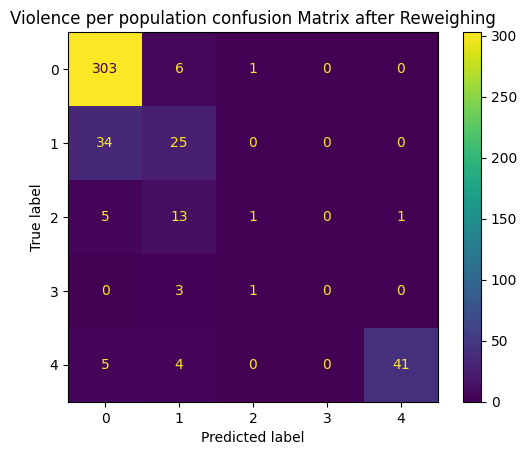

In [43]:
# Confusion matrix
predicted = rw_res['random_forest_0']['prediction']
rw_conf_mtx = sklearn.metrics.confusion_matrix(rw_targ_test, predicted)
init_cf_displ = sklearn.metrics.ConfusionMatrixDisplay(rw_conf_mtx)

rw_perf = {
        'Precision': sklearn.metrics.precision_score(rw_targ_test, predicted, average="weighted", zero_division=True),
        'Accuracy': sklearn.metrics.accuracy_score(rw_targ_test, predicted),
        'F1-Score': sklearn.metrics.f1_score(rw_targ_test, predicted, average="weighted"),
        'Recall': sklearn.metrics.recall_score(rw_targ_test, predicted, average="weighted", zero_division=True)
    }

init_cf_displ.plot()
# plt.text(0, 12, ' '.join([k + str(i) + '\n' for k, i in rw_perf.items()]))
plt.title('Violence per population confusion Matrix after Reweighing')
plt.show()

In [42]:
display(Markdown('**Random Forest performance after reweighing**'))
display(Markdown(f'***Accuracy {round(rw_perf["Accuracy"] * 100, 2)} %***'))
display(Markdown(f'***Precision {round(rw_perf["Precision"] * 100, 2)} %***'))
display(Markdown(f'***F1-Score {round(rw_perf["F1-Score"] * 100, 2)} %***'))
display(Markdown(f'***Recall {round(rw_perf["Recall"] * 100, 2)} %***'))

**Random Forest performance after reweighing**

***Accuracy 83.52 %***

***Precision 81.06 %***

***F1-Score 81.05 %***

***Recall 83.52 %***

In [45]:
from aif360.metrics import BinaryLabelDatasetMetric

rw_classf_metr = BinaryLabelDatasetMetric(dataset=rw['reweighing_0']['transformed'],
                                          unprivileged_groups=unpriv_group,
                                          privileged_groups=priv_group)

rw_aif360_perf = {
"Disparate impact": rw_classf_metr.disparate_impact(),
"Smoothed empricial differential fairness": rw_classf_metr.smoothed_empirical_differential_fairness(),
"Statistical parity": rw_classf_metr.statistical_parity_difference()
}

print(rw_aif360_perf)

{'Disparate impact': 0.0, 'Smoothed empricial differential fairness': 0.7211542397171378, 'Statistical parity': -1.0}


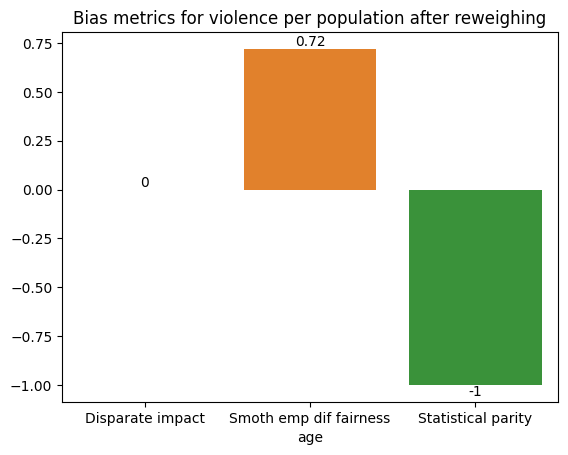

In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


#Result from the Dalc:
# rw_bias_metr_res_dalc = {'Disparate impact': 0.0,
#  'Smoothed empricial differential fairness': 5.528328938742544,
#  'Statistical parity': -1.0}

rw_heat_df = pd.DataFrame({'Disparate impact': 0.0, 'Smoth emp dif fairness': 0.72, 'Statistical parity': -1.0}, index=[0])

ax = sns.barplot(data=rw_heat_df)
ax.set(xlabel='age')

for i in ax.containers:
    ax.bar_label(i,)

plt.title('Bias metrics for violence per population after reweighing')
plt.show()

In [62]:
importlib.reload(calc_metrics)

# Check the model output
display(Markdown('#### Preprocessing ml Classification results'))
display(Markdown('##### Random Forest'))
rw_rf_metr = calc_metrics.calc_metr(predicted=rw_res['random_forest_0']['prediction'], actual=rw_targ_test)
display(Markdown('\n ##### Perceptron'))
rw_perc_metr = calc_metrics.calc_metr(predicted=rw_res['perceptron_1']['prediction'], actual=rw_targ_test)

# Now, let's check the bias metrics
rw_ds: BinaryLabelDataset = rw['reweighing_0']['transformed']
rw_des_test, rw_ds_train = rw_ds.split([0.2])


display(Markdown('#### Preprocessibg Classification metrics'))
rw_bias_metr = calc_metrics.calc_aif360_bin_label_metrics(
                                    dataset=rw['reweighing_0']['transformed'],
                                    unpriviledged=unpriv_group, 
                                    priviledged=priv_group)

#### Preprocessing ml Classification results

##### Random Forest

Precision: 0.8527959601294738
Accuracy: 0.8690744920993227
F1-Score: 0.8500494816773088
Recall: 0.8690744920993227



 ##### Perceptron

Precision: 0.6739866822674916
Accuracy: 0.7291196388261851
F1-Score: 0.6587715760624029
Recall: 0.7291196388261851


#### Preprocessibg Classification metrics

Mean difference = -1.000000
Consistency = 0.916208
Disparate impact = 0.000000


At least some results could be calculated. Overall, the metrics are generally higher than the student dataset

## Inprocessing

Note: Apparently, adversarial debiasing allows only one privileged and one unprivileged group. So we redefine the privileged and unprivileged groups.

In [ ]:
adv_priv_group = [	{'pctWhite': 1}]
adv_unpriv_group = [{'pctBlack': 0}]
# Split the dataframes
feat_train, feat_test, targ_train, targ_test = sklearn.model_selection.train_test_split(cleaned, targ_class, test_size=0.2)
# Split the preprocessed data
rw_train, rw_test = rw['reweighing_0']['transformed'].split([0.8], shuffle=True)
# Instantiate 
stud_inp_inst = inprocessing.ExecInprocess(dataset=rw_train)
stud_adv_deb = stud_inp_inst.exec_advesarial_debiasing(unpriviledged=adv_unpriv_group,
                                                      priveledged=adv_priv_group,
                                                      predict=True,
                                                      to_predict=rw_test).return_results()  

In [ ]:
importlib.reload(calc_metrics)

stud_adv_deb_df = stud_adv_deb['adveserial_debiasing_0']['predicted'].convert_to_dataframe()[0]
print(stud_adv_deb_df.shape)

adv_deb_feat_train, adv_deb_feat_test, adv_deb_targ_train, adv_deb_targ_test = sklearn.model_selection.train_test_split(stud_adv_deb_df, targ_test, test_size=0.2)

adv_deb = ml_methods.MlModelProvider(train_feat=adv_deb_feat_train, train_targ=adv_deb_targ_train)

adv_deb_res = adv_deb.random_forest(already_predict=True, test_feat=adv_deb_feat_test).perceptron(already_predict=True, test_feat=adv_deb_feat_test).return_results()
# Check the model output
display(Markdown('#### Preprocessing ml Classification results'))
display(Markdown('##### Random Forest'))
adv_deb_rf_metr = calc_metrics.calc_metr(predicted=adv_deb_res['random_forest_0']['prediction'], actual=adv_deb_targ_test)
display(Markdown('\n ##### Perceptron'))
adv_deb_perc_metr = calc_metrics.calc_metr(predicted=adv_deb_res['perceptron_1']['prediction'], actual=adv_deb_targ_test)

# Now, let's check the bias metrics
adv_deb_train, adv_deb_test =  stud_adv_deb['adveserial_debiasing_0']['predicted'].split([0.2])


display(Markdown('#### Preprocessing Classification metrics'))
rw_bias_metr = calc_metrics.calc_aif360_bin_label_metrics(
                                    dataset=stud_adv_deb['adveserial_debiasing_0']['predicted'],
                                    unpriviledged=unpriv_group, 
                                    priviledged=priv_group)

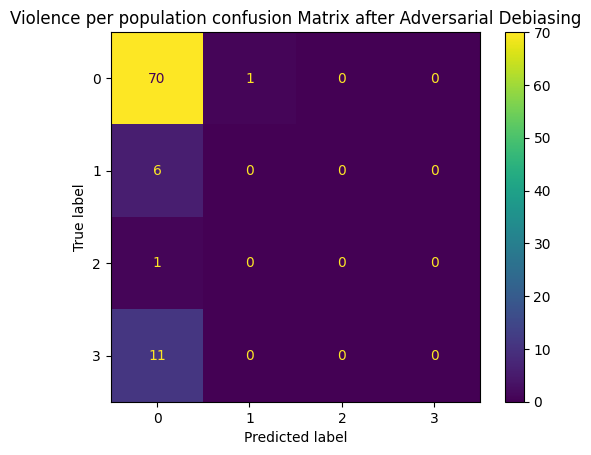

In [53]:
# Confusion matrix
predicted = adv_deb_res['random_forest_0']['prediction']
rw_conf_mtx = sklearn.metrics.confusion_matrix(adv_deb_targ_test, predicted)
init_cf_displ = sklearn.metrics.ConfusionMatrixDisplay(rw_conf_mtx)

adv_deb_perf = {
        'Precision': sklearn.metrics.precision_score(adv_deb_targ_test, predicted, average="weighted", zero_division=True),
        'Accuracy': sklearn.metrics.accuracy_score(adv_deb_targ_test, predicted),
        'F1-Score': sklearn.metrics.f1_score(adv_deb_targ_test, predicted, average="weighted"),
        'Recall': sklearn.metrics.recall_score(adv_deb_targ_test, predicted, average="weighted", zero_division=True)
    }

init_cf_displ.plot()
# plt.text(0, 12, ' '.join([k + str(i) + '\n' for k, i in rw_perf.items()]))
plt.title('Violence per population confusion Matrix after Adversarial Debiasing')
plt.show()

In [52]:
display(Markdown('**Random Forest performance after adversarial debiasing**'))
display(Markdown(f'***Accuracy {round(adv_deb_perf["Accuracy"] * 100, 2)} %***'))
display(Markdown(f'***Precision {round(adv_deb_perf["Precision"] * 100, 2)} %***'))
display(Markdown(f'***F1-Score {round(adv_deb_perf["F1-Score"] * 100, 2)} %***'))
display(Markdown(f'***Recall {round(adv_deb_perf["Recall"] * 100, 2)} %***'))

**Random Forest performance after adversarial debiasing**

***Accuracy 78.65 %***

***Precision 76.94 %***

***F1-Score 70.24 %***

***Recall 78.65 %***

In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric

rw_classf_metr = BinaryLabelDatasetMetric(dataset=stud_adv_deb['adveserial_debiasing_0']['predicted'],
                                          unprivileged_groups=unpriv_group,
                                          privileged_groups=priv_group)

rw_aif360_perf = {
"Disparate impact": rw_classf_metr.disparate_impact(),
"Smoothed empricial differential fairness": rw_classf_metr.smoothed_empirical_differential_fairness(),
"Statistical parity": rw_classf_metr.statistical_parity_difference()
}
import pprint
pprint.pp(rw_aif360_perf)

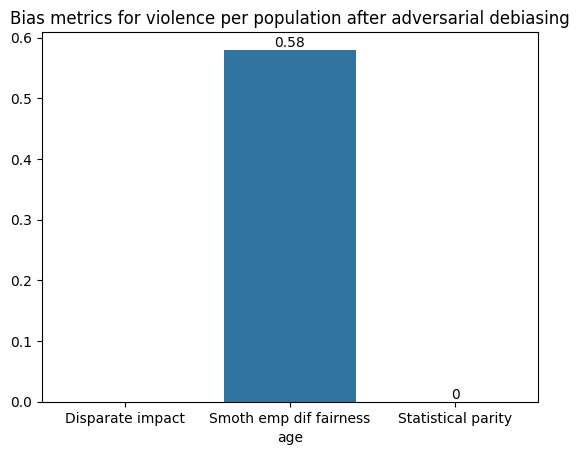

In [57]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt



rw_heat_df = pd.DataFrame({'Disparate impact': np.nan, 'Smoth emp dif fairness': 0.58, 'Statistical parity': 0.0}, index=[0])

ax = sns.barplot(data=rw_heat_df, palette="Paired")
ax.set(xlabel='age')

for i in ax.containers:
    ax.bar_label(i,)

plt.title('Bias metrics for violence per population after adversarial debiasing')
plt.show()

In [ ]:
importlib.reload(calc_metrics)

display(Markdown('#### Inprocessing Classification metrics'))
rw_bias_metr = calc_metrics.calc_aif360_bias_metrics(
                                    mitigated=stud_adv_deb['adveserial_debiasing_0']['predicted'],
                                    original_ds=rw_test,
                                    unpriviledged=unpriv_group, 
                                    priviledged=priv_group
                                    )

## Postprocessing

In [67]:
importlib.reload(postprocessing)

# no_mit_rf_pred_ds = inst_dataset.DatasetInstantiater(train=)

stud_inp_inst = postprocessing.ExecPostprocess(dataset=rw_test)
stud_ceq_odds = stud_inp_inst.exec_cal_equalized_odds(unpriviledged=unpriv_group,
                                                      priveledged=priv_group,
                                                      predicted=stud_adv_deb['adveserial_debiasing_0']['predicted']).return_results()   


print(stud_ceq_odds['eq_odds_0']['fitted'])

In [ ]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing, CalibratedEqOddsPostprocessing

stud_post_inst = CalibratedEqOddsPostprocessing(unprivileged_groups=unpriv_group,
                                                privileged_groups=priv_group)
post_predicted = stud_post_inst.fit_predict(dataset_pred=stud_adv_deb['adveserial_debiasing_0']['predicted'], dataset_true=rw_test)

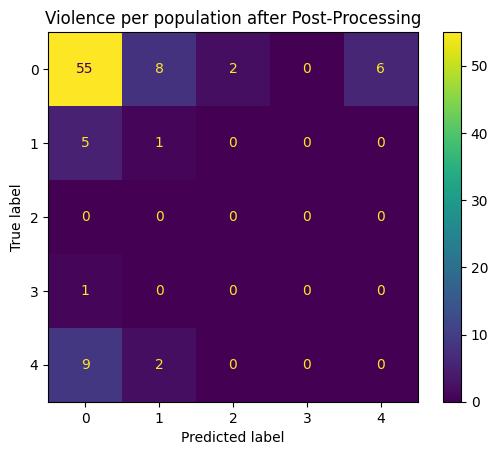

In [61]:
post_pred_df = post_predicted.convert_to_dataframe()[0]

post_feat_train, post_feat_test, post_targ_train, post_targ_test = sklearn.model_selection.train_test_split(post_pred_df, targ_test, test_size=0.2)


rw_conf_mtx = sklearn.metrics.confusion_matrix(adv_deb_targ_test, post_targ_test)
init_cf_displ = sklearn.metrics.ConfusionMatrixDisplay(rw_conf_mtx)

post_perf = {
        'Precision': sklearn.metrics.precision_score(adv_deb_targ_test, post_targ_test, average="weighted", zero_division=True),
        'Accuracy': sklearn.metrics.accuracy_score(adv_deb_targ_test, post_targ_test),
        'F1-Score': sklearn.metrics.f1_score(adv_deb_targ_test, post_targ_test, average="weighted"),
        'Recall': sklearn.metrics.recall_score(adv_deb_targ_test, post_targ_test, average="weighted", zero_division=True)
    }

init_cf_displ.plot()
# plt.text(0, 12, ' '.join([k + str(i) + '\n' for k, i in rw_perf.items()]))
plt.title('Violence per population after Post-Processing')
plt.show()

In [60]:
display(Markdown('**Random Forest performance after post-processing**'))
display(Markdown(f'***Accuracy {round(post_perf["Accuracy"] * 100, 2)} %***'))
display(Markdown(f'***Precision {round(post_perf["Precision"] * 100, 2)} %***'))
display(Markdown(f'***F1-Score {round(post_perf["F1-Score"] * 100, 2)} %***'))
display(Markdown(f'***Recall {round(post_perf["Recall"] * 100, 2)} %***'))

**Random Forest performance after post-processing**

***Accuracy 64.04 %***

***Precision 68.19 %***

***F1-Score 65.98 %***

***Recall 64.04 %***

In [ ]:
from aif360.metrics import BinaryLabelDatasetMetric
import pprint

post_classf_metr = BinaryLabelDatasetMetric(dataset=post_predicted,
                                          unprivileged_groups=unpriv_group,
                                          privileged_groups=priv_group)

post_aif360_perf = {
"Disparate impact": post_classf_metr.disparate_impact(),
"Smoothed empricial differential fairness": post_classf_metr.smoothed_empirical_differential_fairness(),
"Statistical parity": post_classf_metr.statistical_parity_difference()
}

pprint.pp(post_aif360_perf)

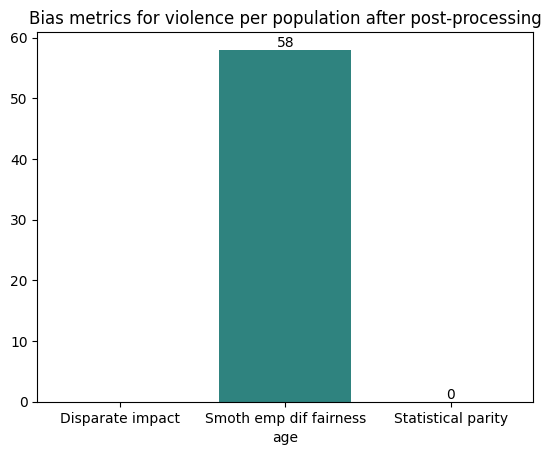

In [65]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt



rw_heat_df = pd.DataFrame({'Disparate impact': np.nan, 'Smoth emp dif fairness': 58, 'Statistical parity': 0.0}, index=[0])

ax = sns.barplot(data=rw_heat_df, palette="viridis")
ax.set(xlabel='age')

for i in ax.containers:
    ax.bar_label(i,)

plt.title('Bias metrics for violence per population after post-processing')
plt.show()

In [68]:
# And now for the classification metrics
importlib.reload(calc_metrics)

display(Markdown('#### Postprocessing Classification metrics'))
rw_bias_metr = calc_metrics.calc_aif360_bias_metrics(
                                    mitigated=stud_ceq_odds['eq_odds_0']['fitted'].predict(rw_train),
                                    original_ds=rw_train,
                                    unpriviledged=unpriv_group, 
                                    priviledged=priv_group
                                    )

#### Postprocessing Classification metrics

Classification accuracy = 1.000000
Balanced classification accuracy = 1.000000
Disparate impact = 0.000000
Equal opportunity difference = nan
Average odds difference = nan
Theil_index = 0.000000


Postprocessing did not appear to have any effect on the bias metrics.